# 文本分类

In [11]:
# 分词
# 词语 -> id
#   matrix -> [|V|, embed_size]
#   词语A -> id(5)
#   词表

# label -> id

import sys
import os
import jieba # pip install jieba

base_dir = './data/cnews/'

# input files
train_file = base_dir + 'cnews.train.txt'
val_file = base_dir + 'cnews.val.txt'
test_file = base_dir + 'cnews.test.txt'

# output files
seg_train_file = base_dir + 'cnews.train.seg.txt'
seg_val_file = base_dir + 'cnews.val.seg.txt'
seg_test_file = base_dir + 'cnews.test.seg.txt'

vocab_file = base_dir + 'cnews.vocab.txt'
category_file = base_dir + 'cnews.category.txt'

In [13]:
!pwd
if not os.path.exists(train_file):
    print('{}不存在, 开始下载文件'.format(train_file))
    !wget http://dikers.nwcd.s3-website-us-east-1.amazonaws.com/data-set/cnews_data.zip
    !unzip ./cnews_data.zip
    !rm ./cnews_data.zip
    !mkdir ./data/cnews 
    !mv cnews.train.txt ./data/cnews/
    !mv cnews.test.txt ./data/cnews/
    !mv cnews.val.txt ./data/cnews/
else:
    print('文件已经存在')

/home/ec2-user/examples/github/machine-learn/deep-learning
文件已经存在


### 使用jieba分词


In [15]:
with open(val_file, 'r') as f:
    lines = f.readlines()

label, content = lines[0].strip('\r\n').split('\t')
word_iter = jieba.cut(content)

print('label', label)
print(content)
print('/ '.join(word_iter))

label 体育
黄蜂vs湖人首发：科比带伤战保罗 加索尔救赎之战 新浪体育讯北京时间4月27日，NBA季后赛首轮洛杉矶湖人主场迎战新奥尔良黄蜂，此前的比赛中，双方战成2-2平，因此本场比赛对于两支球队来说都非常重要，赛前双方也公布了首发阵容：湖人队：费舍尔、科比、阿泰斯特、加索尔、拜纳姆黄蜂队：保罗、贝里内利、阿里扎、兰德里、奥卡福[新浪NBA官方微博][新浪NBA湖人新闻动态微博][新浪NBA专题][黄蜂vs湖人图文直播室](新浪体育)
黄蜂/ vs/ 湖人/ 首发/ ：/ 科比/ 带伤/ 战/ 保罗/  / 加索尔/ 救赎/ 之战/  / 新浪/ 体育讯/ 北京/ 时间/ 4/ 月/ 27/ 日/ ，/ NBA/ 季后赛/ 首轮/ 洛杉矶/ 湖人/ 主场/ 迎战/ 新奥尔良/ 黄蜂/ ，/ 此前/ 的/ 比赛/ 中/ ，/ 双方/ 战成/ 2/ -/ 2/ 平/ ，/ 因此/ 本场/ 比赛/ 对于/ 两支/ 球队/ 来说/ 都/ 非常/ 重要/ ，/ 赛前/ 双方/ 也/ 公布/ 了/ 首发/ 阵容/ ：/ 湖人队/ ：/ 费舍尔/ 、/ 科比/ 、/ 阿泰斯特/ 、/ 加索尔/ 、/ 拜纳姆/ 黄蜂队/ ：/ 保罗/ 、/ 贝里/ 内利/ 、/ 阿里/ 扎/ 、/ 兰德/ 里/ 、/ 奥卡福/ [/ 新浪/ NBA/ 官方/ 微博/ ]/ [/ 新浪/ NBA/ 湖人/ 新闻动态/ 微博/ ]/ [/ 新浪/ NBA/ 专题/ ]/ [/ 黄蜂/ vs/ 湖人/ 图文/ 直播室/ ]/ (/ 新浪/ 体育/ )


###  将样本文件分词

In [17]:
def generate_seg_file(input_file, output_seg_file):
    """Segment the sentences in each line in input_file"""
    with open(input_file, 'r') as f:
        lines = f.readlines()
    with open(output_seg_file, 'w') as f:
        for line in lines:
            label, content = line.strip('\r\n').split('\t')
            word_iter = jieba.cut(content)
            word_content = ''
            for word in word_iter:
                word = word.strip(' ')
                if word != '':
                    word_content += word + ' '
            out_line = '%s\t%s\n' % (label, word_content.strip(' '))
            f.write(out_line)
        print('{} 文件分割完成, 输出路径{} .'.format(input_file, output_seg_file))
        
if not os.path.exists(seg_train_file):
    generate_seg_file(train_file, seg_train_file)
if not os.path.exists(seg_val_file):
    generate_seg_file(val_file, seg_val_file)
if not os.path.exists(seg_test_file):
    generate_seg_file(test_file, seg_test_file)

### 生成词汇表

In [18]:
def generate_vocab_file(input_seg_file, output_vocab_file):
    with open(input_seg_file, 'r') as f:
        lines = f.readlines()
    word_dict = {}
    for line in lines:
        label, content = line.strip('\r\n').split('\t')
        for word in content.split():
            word_dict.setdefault(word, 0)
            word_dict[word] += 1
    # [(word, frequency), ..., ()]
    sorted_word_dict = sorted(
        word_dict.items(), key = lambda d:d[1], reverse=True)
    with open(output_vocab_file, 'w') as f:
        f.write('<UNK>\t10000000\n')
        for item in sorted_word_dict:
            f.write('%s\t%d\n' % (item[0], item[1]))

generate_vocab_file(seg_train_file, vocab_file)

vocab file 格式： 
词语 和 出现的数量

```
生活	13141
能够	12911
不会	12898
不同	12871
获得	12870
城市	12825
学校	12775
一定	12736
一直	12606
上海	12574
```

In [20]:
### 对应的label 标签

In [19]:
def generate_category_dict(input_file, category_file):
    with open(input_file, 'r') as f:
        lines = f.readlines()
    category_dict = {}
    for line in lines:
        label, content = line.strip('\r\n').split('\t')
        category_dict.setdefault(label, 0)
        category_dict[label] += 1
    category_number = len(category_dict)
    with open(category_file, 'w') as f:
        for category in category_dict:
            line = '%s\n' % category
            print('%s\t%d' % (category, category_dict[category]))
            f.write(line)
            
generate_category_dict(train_file, category_file)
            

体育	5000
娱乐	5000
家居	5000
房产	5000
教育	5000
时尚	5000
时政	5000
游戏	5000
科技	5000
财经	5000


### 生成词向量

In [43]:
num_word_threshold = 10
num_timesteps = 50
class Vocab:
    def __init__(self, filename, num_word_threshold):
        self._word_to_id = {}
        self._unk = -1
        self._num_word_threshold = num_word_threshold
        self._read_dict(filename)
    
    def _read_dict(self, filename):
        with open(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            word, frequency = line.strip('\r\n').split('\t')
            frequency = int(frequency)
            if frequency < self._num_word_threshold:
                continue
            idx = len(self._word_to_id)
            if word == '<UNK>':
                self._unk = idx
            self._word_to_id[word] = idx
    
    def word_to_id(self, word):
        return self._word_to_id.get(word, self._unk)
    
    def get_word_dict(self):
        return self._word_to_id
    
    @property
    def unk(self):
        return self._unk
    
    def size(self):
        return len(self._word_to_id)
    
    def sentence_to_id(self, sentence):
        word_ids = [self.word_to_id(cur_word) \
                    for cur_word in sentence.split()]
        return word_ids


class CategoryDict:
    def __init__(self, filename):
        self._category_to_id = {}
        with open(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            category = line.strip('\r\n')
            idx = len(self._category_to_id)
            self._category_to_id[category] = idx
    
    def size(self):
        return len(self._category_to_id)
        
    def category_to_id(self, category):
        if not category in self._category_to_id:
            raise Execption(
                "%s is not in our category list" % category_name)
        return self._category_to_id[category]
        
vocab = Vocab(vocab_file, num_word_threshold)
vocab_size = vocab.size()
print('vocab_size: %d' % vocab_size)

category_vocab = CategoryDict(category_file)
num_classes = category_vocab.size()
print('num_classes: %d' % num_classes)
test_str = '时尚'
print(
    'label: %s, id: %d' % (
        test_str,
        category_vocab.category_to_id(test_str)))

vocab_size: 77323
num_classes: 10
label: 时尚, id: 5


### 生成词的概率分布

In [44]:
import random
import numpy as np
word_counts = vocab.get_word_dict()
threshold = 1e-5
print(word_counts['的'])
total_count = len(word_counts)
print('total_count', total_count)
freqs = {word: count/total_count for word, count in word_counts.items()}
print(freqs['儿童'])
# p_drop = {word: 1 - np.sqrt(threshold/(freqs[word] + 1e-10)) for word in word_counts}
p_drop = {vocab.word_to_id(word): 1 - np.sqrt(threshold/(freqs[word] + 1e-10)) for word in word_counts}
print(p_drop[100]) 

2
total_count 77323
0.03590134888713578
0.9120665058006028


In [47]:
import random
class TextDataSet:
    def __init__(self, filename, vocab, category_vocab, num_timesteps):
        self._vocab = vocab
        self._category_vocab = category_vocab
        self._num_timesteps = num_timesteps
        # matrix
        self._inputs = []
        # vector
        self._outputs = []
        self._indicator = 0
        self._parse_file(filename)
    
    def _parse_file(self, filename):
        print('Loading data from %s', filename)
        with open(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            label, content = line.strip('\r\n').split('\t')
            id_label = self._category_vocab.category_to_id(label)

            id_words = self._vocab.sentence_to_id(content)
            # 过滤掉一部分概率比较低的值
#             print(len(content) , len(id_words))
            id_words = [word for word in id_words if random.random() > (1 - p_drop[word])]

            id_words = id_words[0: self._num_timesteps]
            padding_num = self._num_timesteps - len(id_words)
            id_words = id_words + [
                self._vocab.unk for i in range(padding_num)]
            self._inputs.append(id_words)
            self._outputs.append(id_label)
        self._inputs = np.asarray(self._inputs, dtype = np.int32)
        self._outputs = np.asarray(self._outputs, dtype = np.int32)
        self._random_shuffle()
        self._num_examples = len(self._inputs)
    
    def _random_shuffle(self):
        p = np.random.permutation(len(self._inputs))
        self._inputs = self._inputs[p]
        self._outputs = self._outputs[p]
    
    def num_examples(self):
        return self._num_examples
    
    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > len(self._inputs):
            self._random_shuffle()
            self._indicator = 0
            end_indicator = batch_size
        if end_indicator > len(self._inputs):
            raise Execption("batch_size: %d is too large" % batch_size)
        
        batch_inputs = self._inputs[self._indicator: end_indicator]
        batch_outputs = self._outputs[self._indicator: end_indicator]
        self._indicator = end_indicator
        return batch_inputs, batch_outputs
    
    def get_data(self):
        batch_inputs = self._inputs
        batch_outputs = self._outputs
        return batch_inputs, batch_outputs
        
            
train_dataset = TextDataSet(
    seg_train_file, vocab, category_vocab,num_timesteps) 
val_dataset = TextDataSet(
    seg_val_file, vocab, category_vocab, num_timesteps)
test_dataset = TextDataSet(
    seg_test_file, vocab, category_vocab, num_timesteps)



Loading data from %s /home/ec2-user/examples/github/machine-learn/deep-learning/data/cnews/cnews.train.seg.txt
Loading data from %s /home/ec2-user/examples/github/machine-learn/deep-learning/data/cnews/cnews.val.seg.txt
Loading data from %s /home/ec2-user/examples/github/machine-learn/deep-learning/data/cnews/cnews.test.seg.txt


In [48]:
from keras.utils import to_categorical
print(train_dataset.num_examples())
print(val_dataset.num_examples())
print(test_dataset.num_examples())

x_train , y_train = train_dataset.get_data()
x_val, y_val = val_dataset.get_data()
x_test, y_test  = test_dataset.get_data()
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print('y_train.shape', y_train.shape)
print(x_train[5:8])
print(type(vocab))

50000
5000
10000
(50000, 50)
(5000, 50)
(10000, 50)
y_train.shape (50000, 10)
[[ 7792   807 54269  1854 37546 46534    24 29822   250    16 18430    11
    326  6684    91   678    25    12   187   326   738 36285  1059  3025
      1  5899   104   376  8049     2   596     2   175  6995 16208    20
  10920   192   175  3632     6   192   175 21609     6   707   582  3632
   6652   102]
 [  225   172    15 14489 12331    14 18850  2776  5834  4086   225    13
   4225  2776   129  4086   649  1525   115   744    58   173  3340  2776
   1132 14489 12331    79  6852    90    84  8565     3     4   225 72108
   9210     2 68457   218   115 14023   165   173   174    34   211   433
   2776   165]
 [30474   739  6123   849   422    17   250   428 30474 10889     2  6123
    849   422    64  2289     5  1408 13679     3  1882 13590     5   608
    821     1  6550   324  3262  3744     5  2540     2 33690 27637    20
   3869   804   946   122 11748  5771     2  5182    32  1408   191   739
  64

In [60]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
maxlen = x_test.shape[1]
_epochs = 10
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(vocab_size, 32, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())
# We add the classifier on top
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=_epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val))

print(model.evaluate(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 32)            2474336   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                16010     
Total params: 2,490,346
Trainable params: 2,490,346
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 5000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 344us/step - loss: 0.9331 - acc: 0.7688 - val_loss: 0.4047 - val_acc: 0.8900
Epoch 2/10
50000/50000 [==============================] - 17s 343us/step - l

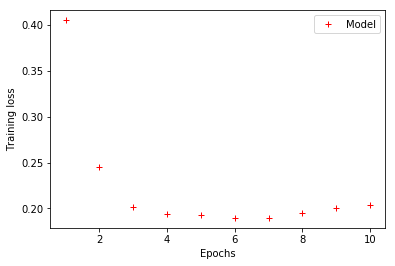

In [61]:
import matplotlib.pyplot as plt
_epochs = 10
epochs = range(1, _epochs+1)
val_loss = history.history['val_loss']
plt.plot(epochs, val_loss, 'b+', color='r',label='Model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

In [ ]:
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=maxlen))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=_epochs,
                    batch_size=64,
                    validation_data=(x_test, y_test))